# Tiny ImageNet Classification with PyTorch

### Classification with ResNet-18

By: Kenneth Leung
___

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1HWfA_JrjoehfZ1zP60MWKo85fBeKccRg?usp=sharing)

___
### 1. Initial setup

In [1]:
pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets aim

In [62]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

import opendatasets as od
import os
from random import randint
import urllib
import zipfile

from aim import Session
from tensorboardX import SummaryWriter

# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Import Datasets

#### Method 1 - Kaggle (Local download)

In [ ]:
# od.download("https://www.kaggle.com/akash2sharma/tiny-imagenet")

#### Method 2 - Direct download (Google Colab)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Retrieve data directly
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2021-08-09 05:33:43--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.6MB/s    in 17s     

2021-08-09 05:34:00 (13.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



___

In [8]:
# Define directory paths
setup = 'Colab' # Local or Colab

if setup == 'Local':
    DATA_DIR = 'tiny-imagenet/tiny-imagenet-200'
else:
    DATA_DIR = 'tiny-imagenet-200'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

Original images come in shape of [3,64,64]

___
### 2. Setup helper functions

In [9]:
# Functions to display single or a batch of sample images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def show_batch(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()    
    imshow(make_grid(images)) # Using Torchvision.utils make_grid function
    
    
def show_image(dataloader):
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    random_num = randint(0, len(images)-1)
    imshow(images[random_num])
    label = labels[random_num]
    print(f'Label: {label}, Shape: {images[random_num].shape}')

In [10]:
def generate_dataloader(data, name, transform):
    if data is None: 
        return None
    
    # Read image files to pytorch dataset with ImageFolder, a generic data 
    # loader where images are in format root/label/filename
    # See https://pytorch.org/vision/stable/datasets.html
    if transform is None:
        dataset = datasets.ImageFolder(data, transform=T.ToTensor())
    else:
        dataset = datasets.ImageFolder(data, transform=transform)

    # Set options for device
    if use_cuda:
        kwargs = {"pin_memory": True, "num_workers": 1}
    else:
        kwargs = {}
    
    # Wrap image dataset (defined above) in dataloader 
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        shuffle=(name=="train"), 
                        **kwargs)
    
    return dataloader

___
### Define Image Pre-processing Transformations
PyTorch transforms define image transformations that convert all images in dataset into a standardized format.

In [11]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained Imagenet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform = T.Compose([
#                 T.Resize(256), # Resize images to 256 x 256
#                 T.CenterCrop(224), # Center crop image
                T.RandomResizedCrop(58),
                T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 
])

___
### Create dataloaders

#### Training set dataloader

In [ ]:
# Define batch size for data loaders
batch_size = 64

In [ ]:
# train_loader = generate_dataloader(TRAIN_DIR, "train",
#                                   transform=None) # No transformations

# # Display batch of UNprocessed images from train set
# show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


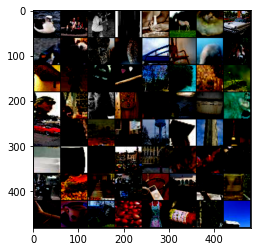

In [13]:
train_loader = generate_dataloader(TRAIN_DIR, "train",
                                  transform=preprocess_transform)

# Display batch of processed images
show_batch(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


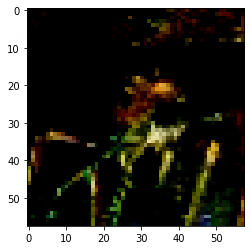

Label: 19, Shape: torch.Size([3, 58, 58])


In [14]:
# Display single random image from train dataset
show_image(train_loader)

#### Validation set dataloader

In [15]:
# Unlike the training folder where the images are already arranged in 
# sub folders based on their labels, the images in the validation folder 
# are all collated in a single folder. The validation folder comes with 
# images folder and val_annotations txt file. The val_annotation txt file 
# comprises 6 tab separated columns of filename, class label, x and y 
# coordinates and height, width of bounding box
val_data = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [16]:
# Create separate validation subfolders for the validation images based on
# their labels indicated in the val_annotations txt file
val_img_dir = os.path.join(VALID_DIR, 'images')

# Open and read val annotations text file
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

# Create dictionary to store img filename (word 0) and corresponding
# label (word 1) for every line in the txt file (as key value pair)
val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

# Display first 10 entries of resulting val_img_dict dictionary
{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [17]:
# Create subfolders (if not present) for validation images based on label ,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [18]:
# Save class names (for corresponding labels) as dict from words.txt file
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

# Display first 20 entries of resulting dictionary
{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


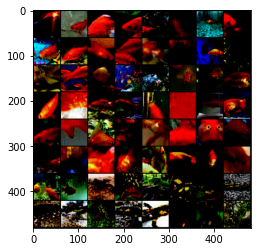

In [19]:
val_loader = generate_dataloader(val_img_dir, "val",
                                 transform=preprocess_transform)

# Display batch of processed images
show_batch(val_loader)

### Define hyperparameters and default values

In [55]:
lr = 0.001  # Learning rate
batch_size = 64  # Images per batch
num_epochs = 10  # Number of epochs

# Set up logging
aim_session = Session()
aim_session.set_params({"lr": lr, "batch_size": batch_size, 
                        "num_epochs": num_epochs}, name="hparams")
print_every = 250  # Number of batches

# Number of output classes
num_classes = 200

___
### Setup and train model
- Making use of PyTorch-Ignite, a high-level library to help with training and evaluating neural networks in PyTorch flexibly and transparently.

#### ResNet-18

In [30]:
# Define model architecture (ResNet)
model = models.resnet18(pretrained=False)

# Define fully connected layer for ResNet
model.fc = torch.nn.Linear(in_features=model.fc.in_features, 
                           out_features=num_classes, 
                           bias=True)
model = model.to(device)

# Set loss function (Categorical Cross Entropy Loss)
loss_func = nn.CrossEntropyLoss()

# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [43]:
# Setup pytorch-ignite trainer
trainer = create_supervised_trainer(
    model,
    optimizer,
    loss_func,
    device=device,
)

# Define metrics
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}

# Setup pytorch-ignite evaluator
evaluator = create_supervised_evaluator(
                model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )

    # evaluate train data
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)

    # evaluate validation data
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # evaluate test data
    # if test_loader:
    #     evaluator.run(test_loader)
    #     log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()

# Start training.
trainer.run(train_loader, max_epochs=num_epochs)

Epoch 1 / 5, batch 500 / 1563: loss: 4.307
Epoch 1 / 5, batch 1000 / 1563: loss: 4.496
Epoch 1 / 5, batch 1500 / 1563: loss: 4.010
Epoch 1 / 5 average results: 
train: loss: 3.980, accuracy: 0.144
val:   loss: 4.021, accuracy: 0.139

--------------------------------------------------------------------------------

Epoch 2 / 5, batch 437 / 1563: loss: 3.581
Epoch 2 / 5, batch 937 / 1563: loss: 3.408
Epoch 2 / 5, batch 1437 / 1563: loss: 3.613
Epoch 2 / 5 average results: 
train: loss: 3.698, accuracy: 0.189
val:   loss: 3.812, accuracy: 0.165

--------------------------------------------------------------------------------

Epoch 3 / 5, batch 374 / 1563: loss: 3.598
Epoch 3 / 5, batch 874 / 1563: loss: 3.454
Epoch 3 / 5, batch 1374 / 1563: loss: 3.641
Epoch 3 / 5 average results: 
train: loss: 3.507, accuracy: 0.224
val:   loss: 3.627, accuracy: 0.206

--------------------------------------------------------------------------------

Epoch 4 / 5, batch 311 / 1563: loss: 3.644
Epoch 4 / 5

State:
	iteration: 7815
	epoch: 5
	epoch_length: 1563
	max_epochs: 5
	output: 3.450308322906494
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [ ]:
evaluator.state.metrics

___
#### DenseNet-121

In [44]:
# Define model architecture (DenseNet)
model = models.densenet121(pretrained=False)

model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, 
                                   out_features=num_classes, bias=True)

model = model.to(device)

# Set loss function (Categorical Cross Entropy Loss)
loss_func = nn.CrossEntropyLoss()

# Set optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

In [46]:
# Set up pytorch-ignite trainer
trainer = create_supervised_trainer(
    model,
    optimizer,
    loss_func,
    device=device,
)
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}

# Set up pytorch-ignite evaluator
evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )
        aim_session.track(metrics["loss"], name="loss", subset=name, epoch=epoch)
        aim_session.track(metrics["accuracy"], name="accuracy", subset=name, epoch=epoch)

    # Train data.
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)

    # Val data.
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # Test data.
    # if test_loader:
    #     evaluator.run(test_loader)
    #     log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()

# Start training.
trainer.run(train_loader, max_epochs=num_epochs)

Epoch 1 / 5, batch 500 / 1563: loss: 4.706
Epoch 1 / 5, batch 1000 / 1563: loss: 4.855
Epoch 1 / 5, batch 1500 / 1563: loss: 4.454
Epoch 1 / 5 average results: 
train: loss: 4.529, accuracy: 0.082
val:   loss: 4.545, accuracy: 0.076

--------------------------------------------------------------------------------

Epoch 2 / 5, batch 437 / 1563: loss: 4.600
Epoch 2 / 5, batch 937 / 1563: loss: 4.302
Epoch 2 / 5, batch 1437 / 1563: loss: 4.043
Epoch 2 / 5 average results: 
train: loss: 4.265, accuracy: 0.121
val:   loss: 4.325, accuracy: 0.117

--------------------------------------------------------------------------------

Epoch 3 / 5, batch 374 / 1563: loss: 4.037
Epoch 3 / 5, batch 874 / 1563: loss: 3.903
Epoch 3 / 5, batch 1374 / 1563: loss: 3.711
Epoch 3 / 5 average results: 
train: loss: 3.838, accuracy: 0.169
val:   loss: 3.898, accuracy: 0.161

--------------------------------------------------------------------------------

Epoch 4 / 5, batch 311 / 1563: loss: 3.947
Epoch 4 / 5

State:
	iteration: 7815
	epoch: 5
	epoch_length: 1563
	max_epochs: 5
	output: 3.8519527912139893
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [47]:
!aim up

┌--------------------------------------------------------┐
        Aim UI collects anonymous usage analytics.        
                Read how to opt-out here:                 
   https://github.com/aimhubio/aim#anonymized-telemetry   
└--------------------------------------------------------┘
Running Aim UI on repo `/content/.aim`
Open http://127.0.0.1:43800
Press Ctrl+C to exit

Aborted!


In [51]:
evaluator.state.metrics

{'accuracy': 0.2035, 'loss': 3.65790390625}

___
#### AlexNet

In [63]:
model = models.alexnet(pretrained=False)

model.classifier[-1] = torch.nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes, bias=True)
model = model.to(device)

loss_func = nn.CrossEntropyLoss()

# Set optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Setup logging
experiment_id = dt.now().strftime('%Y-%m-%d_%H-%M-%S')
writer = SummaryWriter(logdir=f"logs/{experiment_id}")

In [64]:
trainer = create_supervised_trainer(
        model,
        optimizer,
        loss_func,
        device=device,
)
metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(loss_func),
}
evaluator = create_supervised_evaluator(
    model, metrics=metrics, device=device
)

@trainer.on(Events.ITERATION_COMPLETED(every=print_every))
def log_batch(trainer):
    batch = (trainer.state.iteration - 1) % trainer.state.epoch_length + 1
    print(
        f"Epoch {trainer.state.epoch} / {num_epochs}, "
        f"batch {batch} / {trainer.state.epoch_length}: "
        f"loss: {trainer.state.output:.3f}"
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_epoch(trainer):
    print(f"Epoch {trainer.state.epoch} / {num_epochs} average results: ")

    def log_results(name, metrics, epoch):
        print(
            f"{name + ':':6} loss: {metrics['loss']:.3f}, "
            f"accuracy: {metrics['accuracy']:.3f}"
        )
        writer.add_scalar(f"{name}_loss", metrics["loss"], epoch)
        writer.add_scalar(f"{name}_accuracy", metrics["accuracy"], epoch)

    # Train data.
    evaluator.run(train_loader)
    log_results("train", evaluator.state.metrics, trainer.state.epoch)

    # Val data.
    if val_loader:
        evaluator.run(val_loader)
        log_results("val", evaluator.state.metrics, trainer.state.epoch)

    # Test data.
    # if test_loader:
    #     evaluator.run(test_loader)
    #     log_results("test", evaluator.state.metrics, trainer.state.epoch)

    print()
    print("-" * 80)
    print()

# Start training.
trainer.run(train_loader, max_epochs=num_epochs)

Current run is terminating due to exception: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small
Engine run is terminating due to exception: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small


RuntimeError: ignored

In [ ]:
evaluator.state.metrics

___
### References
- https://github.com/ZohebAbai/Tiny-ImageNet-Challenge/blob/master/TinyImageNet_Network_1.ipynb
- https://blog.paperspace.com/dataloaders-abstractions-pytorch/
- https://github.com/DennisHanyuanXu/Tiny-ImageNet/blob/master/src/data_prep.py)
- https://www.kaggle.com/ivankunyankin/resnet18-from-scratch-using-pytorch
- http://cs231n.stanford.edu/reports/2015/pdfs/banerjee_iyer.pdf
- https://pytorch.org/ignite/quickstart.html
- https://traingenerator.jrieke.com/